In [1]:
from pyspark.sql import SparkSession
import numpy as np

# load the data
spark = SparkSession.builder.master("local[10]").appName("beer_review").getOrCreate()
df = spark.read.json("/project/cmsc25025/beer_review/labeled.json")

In [1]:
# Part 1 - data inspection

# get mean, median and standard deviation of the overall ratings for each beer and brewer
beer_ratings = df.rdd.map(lambda x: (int(x['beer_id']),[int(x['overall'])])).reduceByKey(lambda a,b: a + b)
beer_stats = beer_ratings.map(lambda x: [[np.mean(x[1]),np.median(x[1]),np.std(x[1])]]).reduce(lambda a,b: a + b)
brewer_ratings = df.rdd.map(lambda x: (int(x['brewer']),[int(x['overall'])])).reduceByKey(lambda a,b: a + b)
brewer_stats = brewer_ratings.map(lambda x: [[np.mean(x[1]),np.median(x[1]),np.std(x[1])]]).reduce(lambda a,b: a + b)

print "Showing example mean, median, and standard deviation for beers"
print beer_stats[:5]
print "Showing example mean, median, and standard deviation for brewers"
print brewer_stats[:5]

Showing example mean, median, and standard deviation for beers
[[11.0, 10.0, 2.1602468994692869], [15.935153583617748, 16.0, 1.8230304422792614], [13.0, 13.0, 1.0], [15.621621621621621, 16.0, 1.5130308110571249], [12.5, 12.5, 1.5]]
Showing example mean, median, and standard deviation for brewers
[[12.836223506743737, 13.0, 2.5432971325766625], [15.414285714285715, 16.0, 2.4985301801708322], [11.348958333333334, 12.0, 2.7590946126577864], [7.0, 6.0, 3.7416573867739413], [14.141904761904762, 14.0, 2.2235084939517855]]


For a given beer, the mean and median are similar and the standard deviation is generally small, so overall people have similar taste. In comparison, for a given brewer (across all of their beers), the mean and median are farther apart and the standard deviation is larger. Therefore, people do not have as similar opinions of brewers overall as they do for specific beers.

In [2]:
from scipy.sparse import coo_matrix, csr_matrix, vstack
import json
import string
import math

# Part 2 - sentiment analysis (positive or negative)

# load the vocabulary
with open("/project/cmsc25025/beer_review/vocab_50.json", "r") as f:
         d = json.load(f)
vocab = d.keys()

def getFeatures(review):
    # normalize text and separate by spaces
    words = review.lower().encode('utf-8').translate(string.maketrans("",""), \
                                                     string.punctuation).split()
    # obtain word_ids for vocab words in the review
    word_ids = []
    for i,word in enumerate(words):
        if d.has_key(word):
            word_ids.append(d[word])
    vals = [1]*len(word_ids)
    rows = [0]*len(vals)
    
    # create a sparse matrix feature vector
    result = coo_matrix((vals, (rows,word_ids)), shape=(1,len(vocab))).tocsr()[0]
    return result
    # TODO - drop review if none of the words are in the dictionary        
                              
def predict(beta,x,y):
    
    prob = 1/(1+np.exp(-x.dot(beta)[0]))
    yhat = (1 if prob >= 0.5 else 0)
    return y != yhat
    
def updateBeta(beta,X,error,etta,N,lam):
    
    trans = X.transpose()
    rdd = spark.sparkContext.parallelize([x for x in trans])
    grad = np.array(rdd.map(lambda x: x.multiply(error).sum()/float(N)).collect())
    return beta + etta*(grad - lam)      

In [3]:
import matplotlib.pyplot as plt

# train a model based on text reviews
def train_model_text(train_data,test_data,test_size,epochs,lam):

    # split data into batches
    num_batch = 1000
    batch_split = [1]*num_batch
    batches = train_data.randomSplit(batch_split)
    error = [0]*(num_batch*epochs) # error rate
    neg_ll = [0]*(num_batch*epochs) # negative log likelihood
    
    # initialize beta
    beta = np.zeros(len(vocab))

    for ep in range(epochs):
        print "epoch %d" % ep
        # make a full pass over the training data
        for idx,batch in enumerate(batches):
            
            etta = c1/(math.pow(ep*num_batch+idx+1,c2)) # learning rate
            features = batch.map(lambda x: getFeatures(x['review'])).reduce(lambda a,b: vstack([a,b]))
            score = np.array(batch.map(lambda x: [int(x['overall'] >= 14)]).reduce(lambda a,b: a + b))                
            batch_size = len(score)
    
            # update betas
            feat = spark.sparkContext.parallelize([x for x in features])
            pi = np.array(feat.map(lambda x: [1/(1+np.exp(-x.dot(beta)[0]))]).collect())
            diff = score - pi
            beta = updateBeta(beta,features,diff,etta,batch_size,lam)

            # compute the negative log likelihood
            combined = [(score[k],pi[k]) for k in range(batch_size)]
            rdd = spark.sparkContext.parallelize(combined)
            neg_ll[ep*num_batch+idx] = -rdd.map(lambda x: x[0]*math.log(x[1]) + (1-x[0])*math.log(1-x[1])).sum()
            #print neg_ll[ep*num_batch+idx]
            
            # compute the error rate on the test set
            error[ep*num_batch+idx] = (test_data.map(lambda x: predict(beta,getFeatures(x['review']),int(x['overall'] >= 14))).sum())/float(test_size)
            print error[ep*num_batch+idx]

    return error, neg_ll     

epoch 0
0.351951014399
0.344726229275
0.334787783692
0.332149353423
0.330706545833
0.330155753363
0.329258364657
0.328785489171
0.328565172183
0.328202455191
0.327804809896
0.327546877813
0.327385670261
0.327272824974
0.327122364592
0.326990711758
0.326832190999
0.326740840053
0.326646802314
0.326595753256
0.326542017405
0.326490968347
0.326480221177
0.326421111741
0.326434545704
0.326353941928
0.326297519284
0.326238409849
0.326230349471
0.326179300413
0.326149745695
0.326130938147
0.326074515504
0.326050334371
0.326010032483
0.325985851351
0.325958983425
0.325875692857
0.325875692857
0.325889126819
0.325881066442
0.325867632479
0.325838077761
0.325778968325
0.3257521004
0.325757473985
0.32577359474
0.325746726815
0.325711798512
0.325695677757
0.325684930587
0.325660749454
0.325658062661
0.325655375869
0.325658062661
0.325647315491
0.325644628699
0.325650002284
0.325631194736
0.325617760773
0.325593579641
0.325593579641
0.32558283247
0.325588206055
0.32558283247
0.325566711715
0.32554

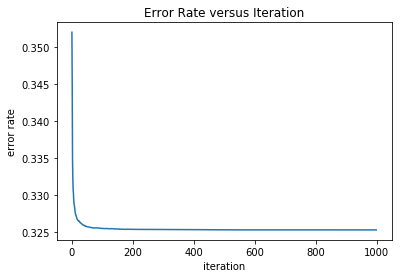

In [4]:
# learning rate parameters
c1 = 1 # learning rate parameters
c2 = 2

# obtain data sets
train, test, validate = df.rdd.randomSplit([0.7,0.15,0.15])
test_size = test.count()
validate_size = validate.count()
    
# select lam using validation set
#lam = [0.2,0.5,2,10] # these can be changed
#epochs = 1 # this can be changed
#for l in lam:
#    train_model_text(train,validate,validate_size,epochs,l)

# train model on both train and validate, using optimized lam
epochs = 1
best_lam = 0.5
training = train.union(validate)
error, neg_ll = train_model_text(training,test,test_size,epochs,best_lam)
plt.figure()
plt.plot(error)
plt.xlabel('iteration')
plt.ylabel('error rate')
plt.title('Error Rate versus Iteration')
plt.show()
    
#plt.figure()
#plt.plot(neg_ll)
#plt.xlabel('iteration')
#plt.ylabel('negative log likelihood')
#plt.title('Negative Log Likelihood versus Iteration')
#plt.show()

The output above shows the error rates after each iteration. At the end of the output you will find a plot of error rate versus iteration and find that it fairly steadily decreases.

We found that a lambda of 0.5 got us the best values for the our error rate. We also found that a step size where we set c2 equal to 2 and c1 equal to 1 got us the best values. Our error rate using the text is about 32.5%. It levels off fairly quickly, possibly because the step size became small as the number of iterations increased.

In [4]:
# train a model based on attribute scores
import matplotlib.pyplot as plt

def getFeatures2(row,col,data):
    return csr_matrix((data, (row, col)), shape=(1, 5))[0]

def train_model_scores(train_data,test_data,test_size,epochs,lam):

    # split data into batches
    num_batch = 10000
    batch_split = [1]*num_batch
    batches = train_data.randomSplit(batch_split)
    error = [0]*(num_batch*epochs) # error rate
    
    # initialize beta
    beta = np.zeros(5)

    row = np.array([0]*5)
    col = np.array([0,1,2,3,4])
    
    for ep in range(epochs):
        # make a full pass over the training data
        for idx,batch in enumerate(batches):
            
            etta = c1/(math.pow(ep*num_batch+idx+1,c2)) # learning rate
            
            scores = batch.map(lambda x:  np.array([x['appearance'] , x['aroma'], x['palate'] , x['style'] ,  x['taste']]))
            features = scores.map(lambda x: getFeatures2(row,col,x)).reduce(lambda a,b: vstack([a,b]))
            
            #features = batch.map(lambda x: getFeatures2(row,col,np.array(x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']))).reduce(lambda a,b: vstack([a,b]))
            score = np.array(batch.map(lambda x: [int(x['overall'] >= 14)]).reduce(lambda a,b: a + b))                
            batch_size = len(score)
    
            # update betas
            feat = spark.sparkContext.parallelize([x for x in features])
            pi = np.array(feat.map(lambda x: [1/(1+np.exp(-x.dot(beta)[0]))]).collect())
            diff = score - pi
            beta = updateBeta(beta,features,diff,etta,batch_size,lam)

            # compute the negative log likelihood
            #combined = [(score[k],pi[k]) for k in range(batch_size)]
            #rdd = spark.sparkContext.parallelize(combined)
            #neg_ll[ep*num_batch+idx] = -rdd.map(lambda x: x[0]*math.log(x[1]) + (1-x[0])*math.log(1-x[1])).sum()
            #print neg_ll[ep*num_batch+idx]
            
            # compute the error rate on the test set
            test_scores = test_data.map(lambda x: (np.array([x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']]), int(x['overall'] >= 14)))
            error[ep*num_batch+idx] = test_scores.map(lambda x: predict(beta,getFeatures2(row,col, x[0]),x[1])).sum()/float(test_size)
            print error[ep*num_batch+idx]
    return error

# learning rate parameters
c1 = 1 # learning rate parameters
c2 = 2

# obtain data sets
train, test, validate = df.rdd.randomSplit([0.7,0.15,0.15])
test_size = test.count()
validate_size = validate.count()
    
# select lam using validation set
#lam = [0.2,0.5,2,10] # these can be changed
#epochs = 1 # this can be changed
#for l in lam:
#    train_model_text(train,validate,validate_size,epochs,l)

# train model on both train and validate, using optimized lam
epochs = 1
best_lam = 1
training = train.union(validate)
error, neg_ll = train_model_scores(training,test,test_size,epochs,best_lam)


plt.figure()
plt.plot(error)
plt.xlabel('iteration')
plt.ylabel('error rate')
plt.title('Error Rate versus Iteration')
plt.show()

0.464779772929
0.531137772768
0.415250825348
0.369082320101
0.464463053923
0.435370534396
0.418058351451
0.394240008589
0.414405346646
0.408787610382
0.401849316907
0.414429503181
0.380248007086
0.381316262716
0.374834259334
0.376294387632
0.376892932872
0.374839627453
0.375974984567
0.374877204284
0.373468073114
0.374222293797
0.373113777277
0.371543602544
0.371457712645
0.370314303352
0.372434710256
0.372268298575
0.372128727487
0.369117212873
0.368612609711
0.367914754274
0.366672034785
0.368354940011
0.368652870601
0.367710765762
0.368974957726
0.367469200419
0.367541670022
0.364758300454
0.36729473656
0.367098800225
0.367407467053
0.367380626459
0.367530933784
0.367726870118
0.367402098934
0.366854550823
0.366808921813
0.367748342593
0.367063907454
0.366892127654
0.367496041012
0.367627559922
0.3675497222
0.367651716456
0.366894811713
0.366685455082
0.366808921813
0.367063907454
0.366902863891
0.367702713584
0.367673188931
0.366647878251
0.367471884478
0.367627559922
0.36772955417

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job 3523 cancelled 
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1375)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor73.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


The output above displays the error rate for each iteration. The prediction error is higher for the logistic regression based on the numerical consumer ratings than it is for the one with text review features. The error begins around 50% and bounces up and down before eventually leveling off around 36.67%. Therefore, the model based on text review features is better than the model based on numerical consumer ratings, implying that the feature vector representation for the text reviews is more powerful than raw numerical scores. This makes sense because the text is of a much higher dimension, containing a lot more info and having the ability to explain a lot more. People are able to use the text to say things they are not able to do just with ratings. In addition, certain types of ratings may not correlate well with the overall rating. We actually compute correlations below and found that style was very weakly related to the overall rating, and appearance was fairly weakly correlated.  

We have generally found that we get the best tradeoff between performance and runtime when we set c_1 equal to 1 and c_2 equal to 2. When we made c_2 smaller it took a very long time to get closer to convergence and when we made c_2 bigger are data was much jumpier and was less clear that we were decreasing constantly. 

Here are some example error rates for the first few iterations using various parameters. 

lam = .5 
0.533179372462
0.462512941833
0.476079737784
0.462512941833
0.52929548149
0.462512941833
0.533452961467
0.462512941833
0.536862095048
0.462512941833...

lam = 1
0.462816251452
0.537183748548
0.462816251452
0.537183748548
0.462816251452
0.531915580225
0.462816251452
0.533257497526
0.462816251452...

lam = 1 , c2 = 2
0.529491011549
0.462184761415
0.462184761415
0.483014077264
0.370363823359
0.395149021877
0.382065415354
0.376743588095
0.368071179105
0.368566668809
0.370725396927...

In [18]:
from pyspark.mllib.stat import Statistics

appear = df.rdd.map(lambda x: np.array(x['appearance']))
arom = df.rdd.map(lambda x: np.array(x['aroma']))   
pal = df.rdd.map(lambda x: np.array(x['palate']))          
style = df.rdd.map(lambda x: np.array(x['style']))
taste = df.rdd.map(lambda x: np.array(x['taste']))
overall = df.rdd.map(lambda x: np.array(x['overall']))

app_corr = Statistics.corr(appear,overall)
arom_corr = Statistics.corr(arom,overall)
pal_corr = Statistics.corr(pal,overall)
style_corr = Statistics.corr(style,overall)
taste_corr = Statistics.corr(taste,overall)

print app_corr
print arom_corr
print pal_corr
print style_corr
print taste_corr

0.53729148393
0.754651751699
0.662880610765
-0.0956428657932
0.808791103723


In [16]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.regression import LabeledPoint

def getFeatures3(review):
    # normalize text and separate by spaces
    words = review.lower().encode('utf-8').translate(string.maketrans("",""), \
                                                     string.punctuation).split()
    # obtain word_ids for vocab words in the review
    word_ids = []
    for i,word in enumerate(words):
        if d.has_key(word):
            word_ids.append(d[word])
    vals = [1]*len(word_ids)
    rows = [0]*len(vals)
    
    # create a sparse matrix feature vector
    result = coo_matrix((vals, (rows,word_ids)), shape=(1,len(vocab))).toarray()[0]
    return result

training = train.map(lambda x: LabeledPoint(int(x['overall'] >= 14),np.concatenate(([x['aroma'], x['palate'], x['taste']],getFeatures3(x['review'])), axis=0)))
testing = test.map(lambda x: LabeledPoint(int(x['overall'] >= 14),np.concatenate(([x['aroma'], x['palate'], x['taste']],getFeatures3(x['review'])), axis=0)))

model = NaiveBayes.train(training, 1.0)
predictionAndLabel = testing.map(lambda p: (model.predict(p.features), p.label))
accuracy = 1.0 * predictionAndLabel.filter(lambda pl: pl[0] == pl[1]).count() / test.count()

print accuracy

0.774703758192


First, we looked at the correlations between each of the 5 scored features with the overall score. We found that appearance and style are the mostly weakly correlated and thus did not include them as features. As features, we used scores for aroma, palate, and taste as well as the text review in the same feature vector form as part 1. A Naive Bayes classifier was trained using the NaiveBayesModel from the pyspark machine learning library. On a sample test set, we were able to obtain ~77.5% accuracy.

In [17]:
# load the data
df_unlabeled = spark.read.json("/project/cmsc25025/beer_review/unlabeled.json")

unlabeled = df_unlabeled.rdd.map(lambda x: (x['review_id'],np.concatenate(([x['aroma'], x['palate'], x['taste']],getFeatures3(x['review'])), axis=0)))
predict = unlabeled.map(lambda p: (p[0],model.predict(p[1]))).collectAsMap()

with open("assn3_prob4_predict.json", "w") as f:
    json.dump(predict, f)